NAME: SmartPort_WSE

COMPATIBILITY: Python 3.10

DESCRIPTION: *UPDATE*

TO RUN        
1. Modify variables where appropriate
2. Run code cells in order                

DATA FORMAT: iPython Notebook

REQUIRES: datetime, influxdb-client, pandas, geopandas, cmath, ipwidgets, warnings, json, functools, shapely, scipy, geocube, numpy, xarray, h5netcdf

TODO          
- [x] Integrate InfluxDB pipeline
- [x] Gage data / river mile join and NA interpolate
- [x] xarray / geocube workflow
- [ ] Automate WSE interpolation, determine method to append output .nc with new values
- [ ] Modifications for production implementation (undefined)

AUTHOR: Harris Bienn

ORGANIZATION: The Water Institute of The Gulf

CONTACT: [hbienn@thewaterinstitute.org](mailto:hbienn@thewaterinstitute.org)

In [1]:
# WSE import and manipulation modules
from dataclasses import dataclass
from datetime import datetime, timezone
from influxdb_client import InfluxDBClient, Point, WritePrecision, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
import pandas as pd
from cmath import nan
import ipywidgets as widgets
from ipywidgets import interactive, TwoByTwoLayout
import geopandas as gpd
# Avoid unnecessary warning about pivot function (not applicable to format)
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.simplefilter("ignore", MissingPivotFunction)

# Geocube/xarray modules
import json
from functools import partial
from shapely.geometry import Point, box, mapping
from scipy.interpolate import griddata, interp1d
from scipy import stats
import numpy as np
import xarray as xr
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
import h5netcdf

%matplotlib inline

##### Get WSE source data using InfluxDB client, return as pandas dataframe, slice to applicable time period, and add missing river mile locations for interpolation.

In [2]:
# Do not modify these settings
token = "ZmsU7WoVdvs45GVB2jNeBzDwJFjza4ZfkQple4FaRqHq8sjxDPnP5kVWOFnVygjbQPY1H_SUcXCU4xX-rn692Q=="
org = "TWI"
bucket = "riverGagesSubset"
client=InfluxDBClient(url="http://10.3.10.19:8086", token=token, org=org,debug=False,enable_gzip=True)
query_api = client.query_api()

@dataclass
class time_query:
  day_query: str
  period_query: str
  # Function to interpolate missing WSE at predetermined RM
  def wse_interp(self):
      # WSE values aggregated over 3h period beginning 00:00z, output references the end of each period  
      # e.g. '2022-09-01 03:00:00+00:00' represents mean values for selected date between 00:00z and 03:00z
      query = f'''from(bucket: "riverGagesSubset")
        |> range(start: {self.day_query}T00:00:00Z, stop: {self.day_query}T23:59:00Z)
        |> filter(fn: (r) => r["_measurement"] == "Stage_Ft")
        |> aggregateWindow(every: 3h, fn: mean, createEmpty: false)
        |> yield(name: "mean")'''
      
      # Import into df, drop and rename columns. 
      wse_df = query_api.query_data_frame(org=org, query=query)
      wse_df = wse_df.drop(columns=["_start","result","table","_field","_stop","_measurement"])
      wse_df = wse_df.rename(columns={"_value": "z", "_time": "time", "Longitude": "lon_g", "Latitude": "lat_g", "Station": "sid", "river_mile": "mile"})
      
      # Modify selected field dtypes to simplify downstream operations
      wse_df[['mile', 'lat_g', 'lon_g']] = wse_df[['mile', 'lat_g', 'lon_g']].apply(pd.to_numeric)
      wse_df['time'] = pd.to_datetime(wse_df['time'],utc=True)
      
      # Pass period selection to create subset dataframe 
      period_select = str(self.day_query + ' ' + self.period_query)
      wse_slice_df = wse_df.loc[wse_df['time'] == period_select]
      
      # Remove gage at Cape Giradeau to fix conflict with river mile join
      bad_gage = "rg_CE401278"
      wse_slice_df = wse_slice_df.loc[wse_slice_df['sid'] != bad_gage]
      
      # Import river mile .geojson into gdf and drop matching columns to simplify following join
      url = "https://raw.githubusercontent.com/hbienn/smartport_wse/main/"
      rm_formatted = f"{url}/mr_rm.geojson"
      rm_gdf = gpd.read_file(rm_formatted, crs="epsg:4326")
      rm_gdf = rm_gdf.drop(columns=['OBJECTID', 'ord', 'sid', 'wse', 'time', 'lat_g', 'lon_g'])
      
      # Round river mile to 1 decimal place to account for any floating precision errors
      rm_gdf = rm_gdf.round({'mile':1})
      rm_gdf = rm_gdf.sort_values('mile')
      rm_gdf = rm_gdf.reindex()
      
      # Merge WSE df with river mile gdf using mile as key
      wse_gdf = rm_gdf.merge(wse_slice_df, how='outer', on='mile')
      
      # Reorder columns for obsessive compulsive reasons
      cols = wse_gdf.columns.tolist()
      cols = ['mile', 'sid', 'z', 'time','lon', 'lat', 'lat_g', 'lon_g', 'geometry']
      wse_gdf = wse_gdf[cols]
      wse_gdf = wse_gdf.sort_values('mile')
      
      # Add column for period and calculate it as max of ['time'] and convert to integer. 
      # Establishes a time dimension for each point that is persistent through the downstream interpolation.
      start_time = wse_gdf['time'].min()
      end_time = wse_gdf['time'].max()
      period = pd.date_range(start=start_time, end=end_time, freq='3H', name='periodIndex')
      period = pd.to_datetime(period.values).view('int64')
      period = period.item()
      wse_gdf.insert(4,'period', period)
      
      # Subset gdf to limit spatial domain to south of RM 1000 in the vicinity of Cape Giradeau, MO
      wse_gdf = wse_gdf.loc[wse_gdf['mile'] <= 1000]
      
      # Interpolates missing WSE values based on a linear relationship between river mile and known WSE values.
      wse_gdf = wse_gdf.dissolve(by='mile', aggfunc='mean')
      wse_gdf = wse_gdf.sort_values('mile')
      wse_gdf['z'] = wse_gdf['z'].interpolate(method='linear', limit_direction = 'both')
      return wse_gdf

t = time_query('2022-03-02', '23:59:00')
wse_gdf = t.wse_interp()
period = int(wse_gdf['period'].mean())


In [ ]:
start_time = '2022-03-01 00:00:00' 
start_day = pd.Timestamp(start_time).strftime('%Y-%m-%d')
today = date.today()
yesterday = today - timedelta(days = 1)
now = datetime.now()
end_time = end_day = yesterday.strftime('%Y-%m-%d')

wse_period_range = pd.date_range(start=start_time, end=end_time, freq='3h')

wse_period_list = wse_period_range.tolist()


#wse_period_list = []

#for i in wse_period_range:
    #wse_period_list.append(i.strftime('%Y-%m-%d %H:%M:%S'))

#wse_period_list = list(map(lambda x: x.replace('00:00:00','23:59:00'), wse_period_list))
#wse_period_list.pop(0)

#wse_period_complete = []

In [ ]:
second_delta = pd.Timedelta("1 minute")
wse_period_range = pd.date_range(start=start_time, end=end_time, freq='3h')
wse_period_range = wse_period_range.to_frame(index=True)
x = wse_period_range.at_time('00:00:00')
#x = wse_period_range.indexer_at_time('00:00:00')

#wse_period_range = list(map(lambda x: x.replace(wse_period_range.at_time(),'23:59:00'), wse_period_range))
#wse_period_range.loc
#wse_period_range = list(map(lambda x: x.replace()))

##### Make geocube/xarray from geodataframe

In [3]:
# User modified variables
bounding_box = json.dumps(mapping(box(-92,28.5,-89,31.5))) # Not implemented 
projection = "EPSG:26915"
resolution = r = 1000

def wse_cube():
    # Still issues here with getting make_geocube to recognize time field and assign it correct dtype (datetime64[ns]). 
    # Potentially results from use of a timezone-aware dtype, workaround implemented.
    wse_xr = make_geocube(
        vector_data = wse_gdf,
        measurements = ['z',],
        #datetime_measurements=['period'],
        output_crs = projection,
        resolution = (r, r),
        #geom = bounding_box,
        #interpolate_na_method='linear'
        rasterize_function=partial(rasterize_points_griddata, method="linear", filter_nan = True)
    )

    # Expand dimensions and populate with the POSIX time value variable previously assigned 
    wse_xr = wse_xr.expand_dims('time')
    arr = wse_xr['time'].to_numpy()
    arr[0,]=period
    wse_xr['time']=arr
    wse_xr['time'] = pd.to_datetime(wse_xr['time'],utc=True)

    # Clip surface to extent of Mississippi River
    url = "https://raw.githubusercontent.com/hbienn/smartport_wse/main/"
    mr_formatted = f"{url}/generalized_nhdarea_stlouistogulf_utm.geojson"
    mr = gpd.read_file(mr_formatted, crs=projection)
    wse_xr = wse_xr.rio.clip(mr.geometry, mr.crs, drop=True, invert=False)
    #wse_xr.to_netcdf("Z:/Documents/ArcGIS/Projects/Smartport/smartport_wse_utm15n_160m_{}.nc".format(period))
    return wse_xr

wse_xr = wse_cube()
wse_xr

<xarray.Dataset>
Dimensions:      (y: 924, x: 238, time: 1)
Coordinates:
  * y            (y) float64 3.206e+06 3.206e+06 ... 4.128e+06 4.128e+06
  * x            (x) float64 6.275e+05 6.285e+05 ... 8.635e+05 8.645e+05
  * time         (time) object 1646265539999999488
    spatial_ref  int32 0
Data variables:
    z            (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

##### Optional figure generation

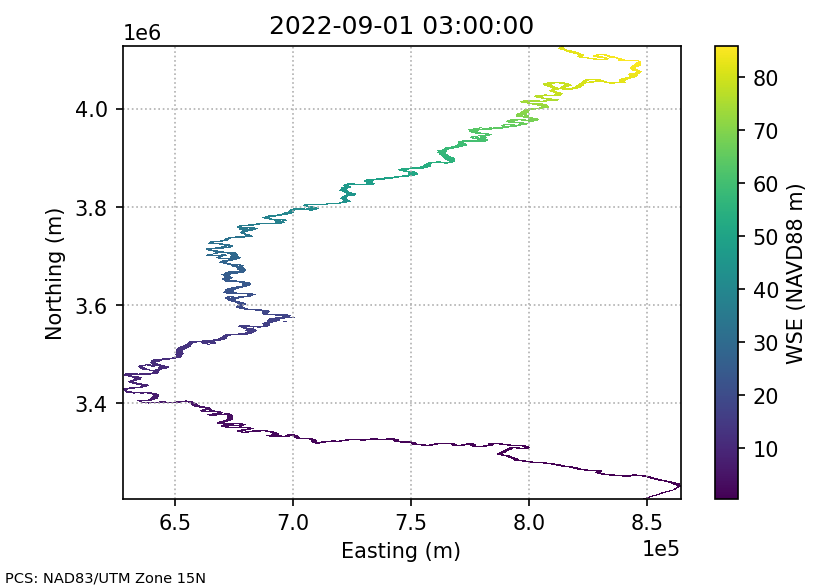

In [16]:
plot = wse_xr.z.where(wse_xr.z!=wse_xr.z.rio.nodata).plot()
plot.axes.set_xlabel('Easting (m)')
plot.axes.set_ylabel('Northing (m)')
plot.axes.set_title(str(pd.to_datetime(period)))
plot.axes.grid(True, linestyle='dotted')
plot.axes.tick_params()
plot.axes.ticklabel_format(axis = 'both', style='sci', scilimits=(0,0))
plot.colorbar.set_label('WSE (NAVD88 m)')
plot.axes.annotate('PCS: NAD83/UTM Zone 15N', xy=(5,5), xycoords='figure pixels',fontsize=7 )
plot.figure.set_dpi(150) # 300 is best for export
#plot.figure.savefig("Z:/Documents/ArcGIS/Projects/Smartport/smartport_wse_utm15n_160m_br2gom.jpg", transparent=False,)
